<a href="https://colab.research.google.com/github/filizolalab/MaxCal_reweigh/blob/main/Dimer_in_WCA_Fl_Kinetic_model_from_metadynamics_and_maxcal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Toy-model kinetic estimate from metadynamics and maximum caliber
*Derya Meral & [Davide Provasi](mailto:davide.provasi@gmail.com) - Filizola Lab (ISMMS, 2022)*


Implements a toy model (open/closed dimer in Weeks-Chandler-Andersen fluid) for the reweigthing of a metadynamics run using maxcal.

#### **Some relevant papers**
* [Meral et al. (2018)](https://aip.scitation.org/doi/full/10.1063/1.5060960) An efficient strategy to estimate thermodynamics and kinetics

* *Reweigh schemes*: [McCarty Parrinello ](https://arxiv.org/pdf/1703.08777.pdf) "A variational conformational dynamics approach to the selection of collective variables in metadynamics". [Tiwary et al.](https://pubs.acs.org/doi/abs/10.1021/jp504920s) A Time-Independent Free Energy Estimator for Metadynamics

* *MaxCal in discrete MSMs* [Dixit et al.  (2014)](https://pubs.acs.org/doi/10.1021/ct5001389) , Inferring Microscopic Kinetic Rates from Stationary State Distributions; *MaxCal in continious MSM* [Dixit & al. (2015)](https://pubs.acs.org/doi/full/10.1021/acs.jctc.5b00537) Inferring Transition Rates of Networks from Populations in Continuous-Time Markov Processes

#### **Other relvant links**
* The double-well dimer is from the `openmmtools` test set ([see here](https://gist.github.com/dwhswenson/bb79a137a1d65629c22e7b00aa569d76))

* Old reweight script from Ludo implementing Tiwary is [here](https://github.com/lud0/comp-bio-tools/blob/master/reweight.py)


In [2]:
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


Install `openmm`, `mdtraj`, and `pyemma`

In [3]:
import condacolab
condacolab.check()

!conda install -y -q -c conda-forge openmm python=3.7 pdbfixer openmmtools pyemma 2>&1 1>/dev/null
!pip install mdtraj

✨🍰✨ Everything looks OK!


In [4]:
## install conda without condacolab -- slower

#%%time
#!wget -qnc https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh 
#!bash Miniconda3-latest-Linux-x86_64.sh -bfp /usr/local 2>&1 1>/dev/null
#!rm Miniconda3-latest-Linux-x86_64.sh 2>&1 1>/dev/null
#!conda install -y -q -c conda-forge openmm=7.6 python=3.7 pdbfixer openmmtools 2>&1 1>/dev/null

# sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [5]:
import os
import sys
from sys import stdout

import openmm.testInstallation
openmm.testInstallation.main()


OpenMM Version: 7.7
Git Revision: 130124a3f9277b054ec40927360a6ad20c8f5fa6

There are 4 Platforms available:

1 Reference - Successfully computed forces
2 CPU - Successfully computed forces
3 CUDA - Successfully computed forces
4 OpenCL - Successfully computed forces

Median difference in forces between platforms:

Reference vs. CPU: 6.29493e-06
Reference vs. CUDA: 6.72828e-06
CPU vs. CUDA: 7.44632e-07
Reference vs. OpenCL: 6.76359e-06
CPU vs. OpenCL: 8.12818e-07
CUDA vs. OpenCL: 2.71988e-07

All differences are within tolerance.


In [6]:
from openmm.app import *
from openmm import *
from openmm.unit import *
import mdtraj as md

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Run simple MD of a dimer in Weeks-Chandler-Andersen fluid

We first run a unbiased run of the dimer in WCA fluid to have reference values for thermodynamics and kinetics.
There is a single dimer (beads 0 and 1), in a fluid of particles interacting with a WCA potential. 
 
For reasonable values of the temperature, it's easy to sample some transitions.

In [7]:
from openmmtools import integrators, testsystems

In [8]:
# energy in OpenMM is energy/mol, so k in kT is k_B*N_A
# these are the parameters from the default WCA Fluid

kB = BOLTZMANN_CONSTANT_kB * AVOGADRO_CONSTANT_NA
epsilon = 120. * kelvin * kB
sigma = 3.4 * angstroms
sigma_nm = sigma.value_in_unit(nanometer)

mass = 39.9 * dalton
tau = np.sqrt(sigma**2 * mass / epsilon)
density = 0.96
timestep = 0.001 * tau
collision = 2.0/tau #2.5 / tau
temperature = 1.5/ kB * epsilon #0.824 / kB * epsilon

In [9]:
## generate unbiased trajectory
def gen_trj(filename,  write_stride = 1000, total_steps = 50000):
  '''
  generates a unbiased traj. and returns (1) the distance of the dimer particles (CV),
  index 0 and 1; (2) the openmm simulation object
  the full trajectory is saved on disk
  '''

  # setup the system, integrator, sim object
  dw_dimer = testsystems.DoubleWellDimer_WCAFluid()
  system, positions = dw_dimer.system, dw_dimer.positions
  integrator = integrators.BAOABIntegrator(temperature, collision, timestep)
  sim = Simulation(dw_dimer.topology, system, integrator)

  # minimize
  sim.context.setPositions(positions)
  energy_before = sim.context.getState(getEnergy=True).getPotentialEnergy()
  print(f'energy before: {energy_before}')
  sim.minimizeEnergy()
  energy_after = sim.context.getState(getEnergy=True).getPotentialEnergy()
  print(f'energy after: {energy_after}')
  
  # setup reporters
  sim.reporters.clear()
  rep1 = StateDataReporter(stdout, total_steps/5,  step=True, time=True,  potentialEnergy=True, temperature=True)
  sim.reporters.append( rep1 )
  sim.reporters.append(DCDReporter(filename, write_stride))
  
  ## run dynamics
  sim.step(total_steps)
  
  ## readback traj, and calculated dimer CV
  traj = md.load(filename, top=md.Topology.from_openmm(dw_dimer.topology))
  dists = md.compute_distances(traj, atom_pairs=[[0,1]]) / sigma_nm

  return dists, sim


### Run one long MD

We generate one "long" and several "short" trajectories to use as a validation of the metadynamics run.

In [10]:
write_stride = 1000
total_steps = 1000000
dists, sim = gen_trj("dw_dimer.dcd",  write_stride = write_stride, total_steps = total_steps)

energy before: 23843040.0 kJ/mol
energy after: 1.9503483772277832 kJ/mol
#"Step","Time (ps)","Potential Energy (kJ/mole)","Temperature (K)"
200000,430.01900008037285,6.350523948669434,194.81495761183825
400000,860.0380001580367,3.6273350715637207,181.61590848640742
600000,1290.0570002357006,2.306309223175049,173.56630141332434
800000,1720.0760003133644,4.653130054473877,178.90445294984798
1000000,2150.0950004018246,1.2793350219726562,187.83857483953366


Text(0, 0.5, 'dimer distance (sigma units)')

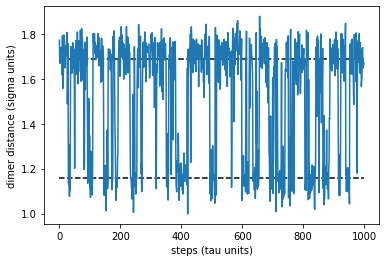

In [76]:

times = np.arange(0,total_steps/write_stride )/(total_steps/write_stride)*sim.context.getTime()/tau

plt.plot(times,dists)
plt.hlines([1.16,1.69],min(times),max(times), linestyles='dashed', label='ave from short' )

plt.xlabel('steps (tau units)')
plt.ylabel('dimer distance (sigma units)')


### Characterise dynamics in long MD (directly and with MSM)

We can characterise the unbiased dynamics by calculating the eq. probabilities and survival times in each state;
also, we calculate the unbiased value of the change in CV
$\langle \delta R(t) \rangle = \langle \vert R(s+t) - R(s) \vert \rangle $ 


In [12]:
# each frame in the saved trajectory corresponds to deltaTau (in tau units)
deltaTau = write_stride/total_steps*sim.context.getTime()/tau

In [13]:
# run-length encoding of the trajectory to calc directly the half-life in each state

def rle_encode(data):
    encoding = []
    prev_char = None
    count = 1
    for char in data:
        if char != prev_char:
            if not prev_char==None:
                encoding.append((count, prev_char))
            count = 1
            prev_char = char
        else:
            count += 1
    else:
        encoding.append((count, prev_char))
    return encoding

In [14]:
nfr = dists.shape[0]
microstates = 1*(dists>1.4).reshape((nfr,))
probs_md = [np.mean(microstates==0), np.mean(microstates==1)] 
print(f'probs: {probs_md}')

rle=rle_encode(microstates)
surv0 = np.mean([le for le,v in rle if v==0])
surv1 = np.mean([le for le,v in rle if v==1])

ssurv0 = np.std([le for le,v in rle if v==0])
ssurv1 = np.std([le for le,v in rle if v==1])


print(f'survival in 0: {surv0:.2f} std {ssurv0:.2f}')
print(f'survival in 1: {surv1:.2f} std {ssurv1:.2f}')

lag=10
cv_jumps_md = np.mean(np.abs(dists[lag:]-dists[:-lag]))
print(f'consraint reference value (from unbiased) {cv_jumps_md:.2f}')


probs: [0.319, 0.681]
survival in 0: 7.09 std 6.96
survival in 1: 14.80 std 15.34
consraint reference value (from unbiased) 0.25


In [15]:
## calc difference in CV bet microstates
dCV = np.mean(dists[microstates==1])-np.mean(dists[microstates==0])
print(f'microstate cv diff {dCV}')

microstate cv diff 0.5315772294998169


The same characterisation using a MSM from this single run

In [16]:
from pyemma import msm
mm_long = msm.estimate_markov_model([microstates], 10)

In [17]:
def eqprobs(mat):
  '''
  returns the eq. probabilities of a stochastic matrix
  '''
  n = mat.shape[0]
  w,v = np.linalg.eig(np.transpose(mat))
  iw = np.argmin((w-1)**2)
  #print((w, iw))
  if np.abs(w[iw]-1)>1e-8:
    print(f' perr eigenval is {w[iw]}')
  perr_v = v[:,iw]/np.sum(v[:,iw])
  return perr_v.reshape((1,n))


def getConst(mat, Rmat):
  '''
  val of dyn average
  '''
  pi = eqprobs(mat)
  return np.sum(np.matmul(pi, mat*Rmat))

In [18]:
print(f'eq. probs: {mm_long.pi}')
print(f'mfpts for the two states {(mm_long.mfpt(0,1), mm_long.mfpt(1,0))}')
print(f'jump ave {getConst(mm_long.P, np.array([[0,dCV],[dCV,0]]))}')

eq. probs: [0.32222222 0.67777778]
mfpts for the two states (17.527472527472526, 36.86813186813187)
jump ave 0.19544859751306395


estimating MaximumLikelihoodMSM:   0%|          | 0/9 [00:00<?, ?it/s]

(<Figure size 432x432 with 4 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8b0d815890>,
       dtype=object))

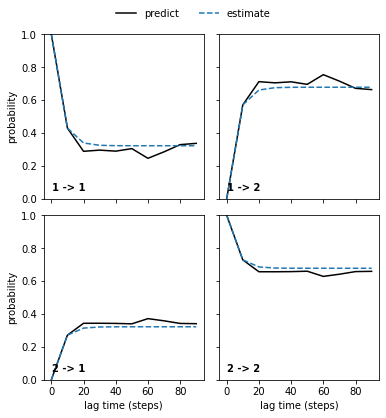

In [19]:
from pyemma.plots import plot_cktest
ck=mm_long.cktest(2)
plot_cktest(ck)

### Run multiple short runs and fit MSM from unbiased trjs

In [20]:
## generate trajs
trjs =  [gen_trj(f'short_unbiased.{it}.dcd', write_stride = 1000, total_steps = 200000)[0] for it in range(20) ]

energy before: 23843040.0 kJ/mol
energy after: 1.9503483772277832 kJ/mol
#"Step","Time (ps)","Potential Energy (kJ/mole)","Temperature (K)"
40000,86.00380001627225,3.810673475265503,182.2978024701388
80000,172.0076000326643,8.53217887878418,197.37591455929478
120000,258.0114000493073,4.098480701446533,160.62148558383987
160000,344.0152000648401,0.9189391136169434,169.88831301085065
200000,430.01900008037285,3.099414825439453,168.93010656292586
energy before: 23843040.0 kJ/mol
energy after: 1.9503483772277832 kJ/mol
#"Step","Time (ps)","Potential Energy (kJ/mole)","Temperature (K)"
40000,86.00380001627225,1.1312214136123657,188.70804546145595
80000,172.0076000326643,5.421695232391357,177.6483759786359
120000,258.0114000493073,2.464263916015625,192.00053770370513
160000,344.0152000648401,1.3788254261016846,179.93498028545304
200000,430.01900008037285,1.595252275466919,175.577578831955
energy before: 23843040.0 kJ/mol
energy after: 1.9503483772277832 kJ/mol
#"Step","Time (ps)","Potential 

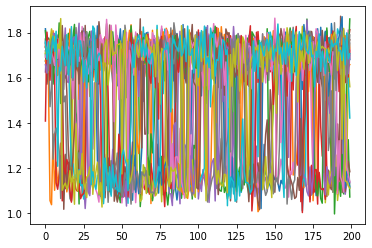

In [80]:
for tr in trjs:
  plt.plot(tr)



In [22]:
dtrajs = [((tr>1.4)*1).reshape((len(tr,))) for tr in trjs]
mm = msm.estimate_markov_model(dtrajs, lag)

estimating MaximumLikelihoodMSM:   0%|          | 0/9 [00:00<?, ?it/s]

(<Figure size 432x432 with 4 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8b0b0d0e90>,
       dtype=object))

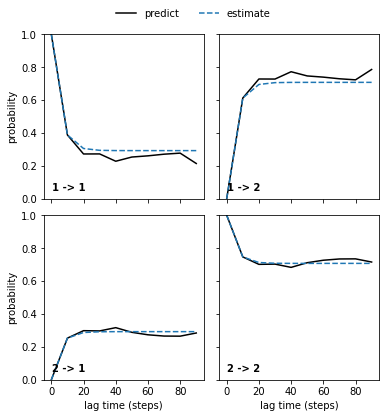

In [23]:
# check conservation
np.sum(mm.P,axis=1)

ck_short=mm.cktest(2)
plot_cktest(ck_short)


In [24]:
print(f'probs from short trajs {mm.pi}')
print(f'probs from long traj {mm_long.pi}')


probs from short trajs [0.29262898 0.70737102]
probs from long traj [0.32222222 0.67777778]


In [25]:
print('mats from short and long')
print(mm.P.round(2))

print(mm_long.P.round(2))

mats from short and long
[[0.39 0.61]
 [0.25 0.75]]
[[0.43 0.57]
 [0.27 0.73]]


In [26]:
print(f'eq. probs: {mm.pi}')
print(f'mfpts for the two states {(mm.mfpt(0,1), mm.mfpt(1,0))}')
print(f'jump ave {getConst(mm.P, np.array([[0,dCV],[dCV,0]]))}')

eq. probs: [0.29262898 0.70737102]
mfpts for the two states (16.33281968533109, 39.481268173994636)
jump ave 0.190481381990729


In [27]:
rle2=[rle_encode(dtr) for dtr in dtrajs]
rle2_flat = [x for z in rle2 for x in z ]

surv0_sh = np.mean([le for le,v in rle2_flat if v==0])
surv1_sh = np.mean([le for le,v in rle2_flat if v==1])
ssurv0_sh = np.std([le for le,v in rle2_flat if v==0])
ssurv1_sh = np.std([le for le,v in rle2_flat if v==1])


print(f'survival in 0 from short: {surv0_sh:.2f} std {ssurv0_sh:.2f}')
print(f'survival in 1 from short: {surv1_sh:.2f} std {ssurv1_sh:.2f}')


survival in 0 from short: 7.01 std 7.25
survival in 1 from short: 16.55 std 16.10


#### calc cv jump rate from short trajs

dyn average (from short unbiased) 0.2404668629169464


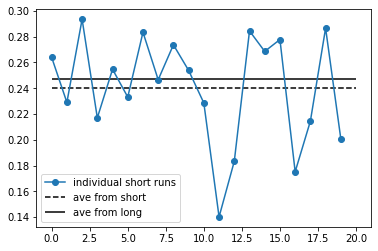

In [72]:
lag=10
cv_jumps_short_mds = [np.mean(np.abs(tr[lag:]-tr[:-lag])) for tr in trjs]
ave_cv_jump_short_mds = np.mean(cv_jumps_short_mds)
print(f'dyn average (from short unbiased) {ave_cv_jump_short_mds}')

plt.plot(cv_jumps_short_mds, label='individual short runs',marker='o')
plt.hlines(ave_cv_jump_short_mds,0,len(cv_jumps_short_mds), linestyles='dashed', label='ave from short' )
plt.hlines(cv_jumps_md,0,len(cv_jumps_short_mds), label='ave from long' )
plt.legend()


#### analytical transition matrix

For a two-state system with one constraint we can calculate the matrix analitically (i.e. tehre is only one transition matrix with given probs and given dynamic average)

In [29]:
#p01 = .1
#p10 = 0.5
#m = np.array([[1-p01,p01],[p10,1-p10]])
# eigenvectors(transpose([[1-z,z],[u,1-u]]))
#ana_probs = np.array([[p10/p01, 1]])/np.sum(np.array([[p10/p01, 1]]))

#p10 = p0/p1*p01 

#constraint: dR ( p0*p01 + p1*p0/p1*p01)  = r0
# p01  = r0/(2 dR p0)

def anamat(p0,p1, dR, r0):
  p01  = r0/(2*dR*p0)
  return np.array([[1-p01,p01],[p0/p1*p01,1-p0/p1*p01]])


In [30]:
anam = anamat(mm.pi[0], mm.pi[1], dCV, ave_cv_jump_short_mds)
anam_pp = eqprobs(anam)

Differences between the analytical matrix and the one from the short MSM

In [31]:
print('analitical mat')
print(anam.round(2))

print('short MSM mat')
print(mm.P.round(2))

print(f'probs: {anam_pp.round(2)}')
print(f'input probs: {mm.pi.round(2)}')


analitical mat
[[0.23 0.77]
 [0.32 0.68]]
short MSM mat
[[0.39 0.61]
 [0.25 0.75]]
probs: [[0.29 0.71]]
input probs: [0.29 0.71]


In [32]:
recalc_cv_jump = getConst(anam, np.array([[0,dCV],[dCV,0]]))

print(f'recalc jump (from analytical mat): {recalc_cv_jump.round(2)}')
print(f'input jump: {ave_cv_jump_short_mds:.2f}')

recalc jump (from analytical mat): 0.24
input jump: 0.24


In [33]:
## jump average from synthetic traj with anal mat

synth_tr=[0]
steps  =range(1000)
for i in steps[1:]:
  j = np.random.choice([0,1],p=(anam)[synth_tr[i-1],:])
  synth_tr.append(j)

strj = dCV*np.array(synth_tr)

print(f'jump from syth traj: {np.mean(np.abs(strj[1:]-strj[:-1])):.2f}')

jump from syth traj: 0.24


## Run metadynamics


Set up a well-temp metadynamics run biasing the dimer distance. 

In [34]:
# bias factor, dep rate, height
gamma = 10
dep_freq = 100
height = epsilon/200

In [35]:
dw_dimer2 = testsystems.DoubleWellDimer_WCAFluid()
system2, positions2 = dw_dimer2.system, dw_dimer2.positions

cv1 = CustomBondForce('r')
cv1.addBond(0,1)
phi = BiasVariable(cv1, 0.5*sigma_nm, 3*sigma_nm, 0.1*sigma_nm, periodic=False)

meta = Metadynamics(system2, [phi], temperature, gamma, height, dep_freq)
print([f.getName() for f in system2.getForces() ])

integrator2 = integrators.BAOABIntegrator(temperature, collision, timestep)
sim2 = Simulation(dw_dimer2.topology, system2, integrator2)

['CustomNonbondedForce', 'CustomBondForce', 'CustomCVForce']


In [36]:
ref_postions2 = sim.context.getState(getPositions=True).getPositions()
sim2.context.setPositions(ref_postions2)

write_stride_meta = int(write_stride)
sim2.reporters.clear()
sim2.reporters.append(DCDReporter("dw_dimer2.dcd", write_stride_meta))

the native `openmm` metadynamics does not have a reporter to access the bias as a function of time, so we save everyting in a (rather inefficient) loop.
We use the same striding as in the position reporter

In [37]:
rep = []
fullfes = []

for ist in range(400):
  meta.step(sim2, write_stride_meta)

  time = sim2.context.getTime() / tau
  pos = sim2.context.getState(getPositions=True).getPositions(asNumpy=True)
  cv = sqrt(sum((pos[0]-pos[1])**2))/(sigma_nm*nanometer)
  bias = sim2.context.getState(getEnergy=True, groups={31}).getPotentialEnergy() / (kB * temperature)
  tot_energy =  sim2.context.getState(getEnergy=True).getPotentialEnergy() / (kB * temperature) 
  rep.append([time, cv, bias, tot_energy])


  # store full fes profile to calculate
  fullfes.append(meta.getFreeEnergy()/(kB * temperature))

In [38]:
rep1=np.vstack(rep)

Text(0, 0.5, 'bias (kt units)')

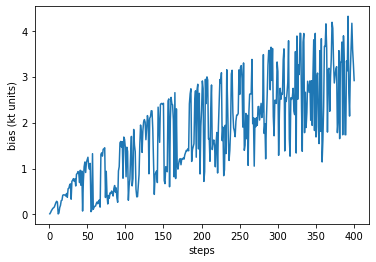

In [39]:
plt.plot(rep1[:,0],rep1[:,2])
plt.xlabel('steps')
plt.ylabel('bias (kt units)')

Text(0, 0.5, 'CV (sigma units)')

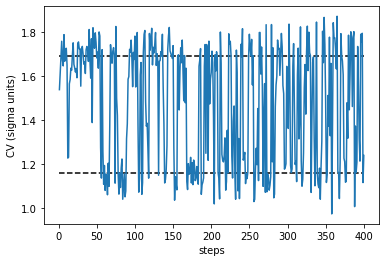

In [81]:
plt.plot(rep1[:,0],rep1[:,1])
plt.hlines([1.16,1.69],min(rep1[:,0]),max(rep1[:,0]), linestyles='dashed', label='ave from short' )

plt.xlabel('steps')
plt.ylabel('CV (sigma units)')

read back the saved traj and compare CVs

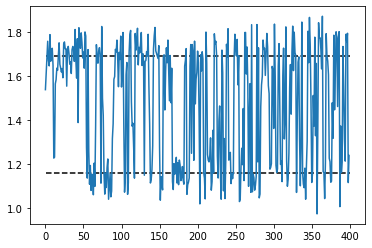

In [82]:
traj2 = md.load("./dw_dimer2.dcd", top=md.Topology.from_openmm(dw_dimer2.topology))
dists2 = md.compute_distances(traj2, atom_pairs=[[0,1]]) / sigma_nm
plt.plot(dists2)
plt.hlines([1.16,1.69],min(rep1[:,0]),max(rep1[:,0]), linestyles='dashed', label='ave from short' )


final FES (from the grid)

Text(0, 0.5, 'fes (kt units)')

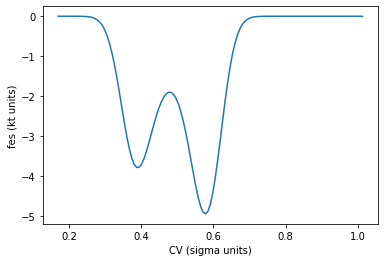

In [42]:
def getGrid(bias):
  grid = [bias.minValue + i*(bias.maxValue-bias.minValue)/bias.gridWidth 
          for i in range(bias.gridWidth)]
  return np.array(grid)


kt = kB * temperature
grid = getGrid(phi)

fes1 = meta.getFreeEnergy()/kt
plt.plot(grid,fes1)
plt.xlabel('CV (sigma units)')
plt.ylabel('fes (kt units)')


Text(0, 0.5, 'fes (kt units)')

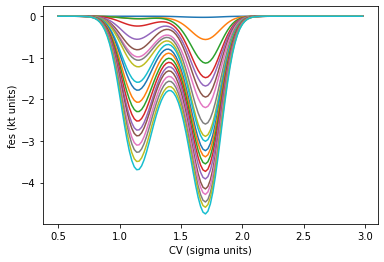

In [43]:
## plot the evolution of the free-energy
fullfes1 = np.vstack(fullfes)

for fes in fullfes1[::20,:]:
  plt.plot(grid/sigma_nm,fes)
plt.xlabel('CV (sigma units)')
plt.ylabel('fes (kt units)')

Calculate the work offset $c(t)$ as in Tiwary and Parrinello JPCB 2014. This is needed to rescale the time and to calc free-energies using the time-independent approach.

following Sutto, the best way it to calc $c(t)$ using using eq. 12 in eq. 3 in the JPCB paper
$$
e^{c(t)} = \frac{\int ds e^{V(s,t)}}{\int ds e^{V(s,t)/\gamma}} 
$$

In [44]:
# this is using directly
num = np.sum(np.exp(-fullfes1[-1,:]))
den = np.sum(np.exp(-(fullfes1[-1,:]+fullfes1)),axis=1)
c = -np.log(num/den)


In [45]:
num = np.sum(np.exp(-fullfes1),axis=1)
den = np.sum(np.exp(-fullfes1/gamma),axis=1)
c2 = np.log(num/den)

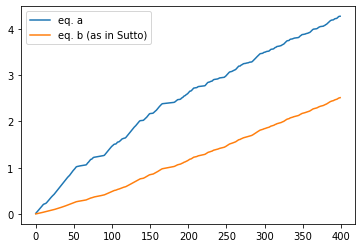

In [46]:
plt.plot(c, label='eq. a')
plt.plot(c2, label='eq. b (as in Sutto)')
plt.legend()

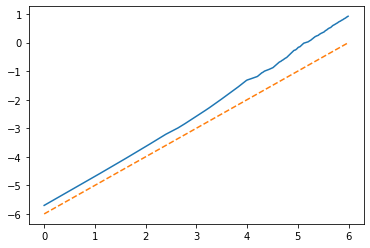

In [70]:
plt.plot(np.log(rep1[:,0]), np.log(c2), label='eq. b (as in Sutto)')
plt.plot([0,6],[-6,0],'--')

In [48]:
## reweigh factor (Tiwary)
omega = np.exp(rep1[:,2]-c2)

In [49]:
d,x = np.histogram(rep1[:,1], bins=30, weights=omega/np.sum(omega))

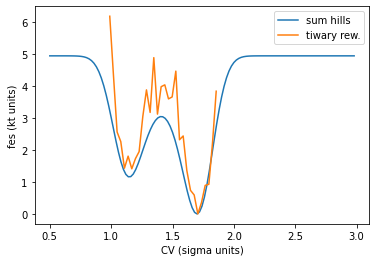

In [50]:
tiwary_fes = -np.log(d/np.sum(d)) - np.min(-np.log(d/np.sum(d)))
sumhills_fes = fullfes1[-1,:] - np.min( fullfes1[-1,:])
plt.plot(grid/sigma_nm, sumhills_fes, label='sum hills')
plt.plot((x[1:]+x[:-1])/2,tiwary_fes, label='tiwary rew.')
plt.xlabel('CV (sigma units)')
plt.ylabel('fes (kt units)')
plt.legend()

In [51]:
rep1.shape

(400, 4)

In [52]:
burnin=int(len(omega)/3*2)

In [53]:
lagm=10
T = np.array(range(burnin,len(omega)))
deltaT = np.array([i+np.argmin(np.abs(np.cumsum(omega[i:])-lagm)) for i in T])
keep = np.array(deltaT)<len(omega)

In [54]:
deltaCV = np.abs(rep1[T[keep],1] - rep1[deltaT[keep],1])
aveCV = np.sum(deltaCV*omega[T[keep]]/np.sum(omega[T[keep]]))

In [55]:

print(f'aveCV from metadyn {aveCV}')
print(f'aveCV from MD {cv_jumps_md}')


aveCV from metadyn 0.28484816457215445
aveCV from MD 0.24734246730804443


## Setup a 2-state MSM from the biased run

To estimate the transition matrix we need 

* the probabilities (which we estimate using the metadynamics free-energy). Here the states are defined as being in the close ($d<1.4$) or open ($d\ge 1.4$) dimeric states. 

* We also need the dynamic average value of the distance $R_i$ jumps across the microstates. We estimate it using the rescaled time from McCarty;
the matrix $R_{ij} = \vert R_i - R_j \vert$ for the jump observable is used in the Dixit maxcal optimization

In [56]:
states = [rep1[:,1]<1.4, rep1[:,1]>=1.4]
pi_inf = np.array([np.sum(omega[state])/np.sum(omega) for state in states])
center_cv = [np.sum(rep1[state,1]*omega[state])/np.sum(omega[state]) for state in states]


print(f'eq. probs from metadyn {pi_inf.round(2)}')
print(f'eq. probs from unbiased MSM {mm.pi.round(2)}')

print(f'centers of micros in cv space {center_cv}')
print(f'dCV from short {center_cv[1]-center_cv[0]} from long {dCV}')

eq. probs from metadyn [0.24 0.76]
eq. probs from unbiased MSM [0.29 0.71]
centers of micros in cv space [1.1658190938922206, 1.7015704421377156]
dCV from short 0.535751348245495 from long 0.5315772294998169


The following functions are simple implementations of the maxcal from  [Dixit et al.  (2014)](https://pubs.acs.org/doi/10.1021/ct5001389).

Here, we work with transition matrices (i.e. fit a discrete-time MSM). In our convention `np.sum(mat,axis=1)` and the evolution of probabilities is $\pi(i+1) = \pi(i) T$ (left mult, probs are row vectors).

In [57]:

def instantneous_tmat(probs):
  '''
  returns the maxcal instantaneous matrix
  '''
  return np.transpose(np.repeat(probs,len(probs),axis=0).reshape((len(probs),len(probs))))

def solveDD(A,pi0_flat, tol=1e-12, niter=20000):
  ndim = A.shape[0]
  def DD(vec):
    return pi0_flat/np.matmul(A, vec)
  vec = (np.zeros(ndim)+1)/ndim
  xi = 0.4
  for i in range(niter):
    dvec = DD(vec)
    vec = (1 - xi) * vec + xi * dvec
    if np.all(np.abs(vec-dvec)<tol):
      break
  #print(DD(vec) - vec)
  return vec

def riequil_tmat(m0_old, piout):
  '''
  maxcal approximation of a matrix with perturbed eq. probabilities
  '''
  phiS = np.sqrt(m0_old*np.transpose(m0_old))
  piout_flat = piout.reshape((piout.shape[1],))
  vec = solveDD(phiS, piout_flat, tol = 1e-18, niter = 300)
  matout = np.outer(vec/piout_flat, vec) * phiS
  return matout


In [58]:
from logging import warning
def lagDis2(alpha, Dis, Adj, pi0, tol=1e-18, niter=300, return_values=False):
  pi0_flat = pi0.reshape((pi0.shape[1],))
  #print(pi0_flat)
  if Adj is None:
    n = pi0.shape[1]
    Adj1 = np.zeros((n,n))*0+1
  else:
    Adj1=np.copy(Adj)
    #print(Adj)
  if len(alpha)!=len(Dis):
    warning("o")  
  alphadis = [Dis[i]*alpha[i] for i in range(len(alpha))]
  alphadis = np.sum(np.array(alphadis),axis=0)
  #print(alphadis)
  vec = solveDD(Adj1 * np.exp(alphadis), pi0_flat, tol = tol, niter = niter)
  #print(vec)
  T = np.outer(vec/pi0_flat, vec) * Adj1 * np.exp(alphadis)

  if not return_values:
    return T
  else:
      vals1 = [np.sum(np.matmul(pi0,T*dis)) for dis in Dis]
      return (vals1, T)


def symm(mat):
  return (np.transpose(mat)+mat)*1/2


In [59]:
## define the observable matrix
dR = np.abs(center_cv[0]-center_cv[1])
Rmat = [np.array([0, dR, dR, 0  ]).reshape((2,2))]


In [60]:
print(f'ave from metadynamics {aveCV.round(2)}')
print(f'calc val in MSM from unbiased runs {getConst(mm.P, Rmat).round(2).round(2)}')
print(f'aveCV from long MD {cv_jumps_md:.2f}')

ave from metadynamics 0.28
calc val in MSM from unbiased runs 0.19
aveCV from long MD 0.25


In [61]:
# make pi row vector
pi_inf0 = pi_inf.reshape((1,2))

print(f'use these as eq. probabilities: {pi_inf0}')
print(f'use this as constraint value: {aveCV}')

use these as eq. probabilities: [[0.24013543 0.75986457]]
use this as constraint value: 0.28484816457215445


We can now solve the optimization of the lagrange multipliers

In [62]:
from scipy.optimize import minimize



def optf(alphas): 
  calc_val, mat = lagDis2(alphas, Rmat, None, pi_inf0,return_values=True)
  return np.sum((np.array(calc_val) - np.array(aveCV))**2)

alphas = [0.001]
res = minimize(optf, alphas, tol=1e-8)
calc_vals, mat = lagDis2(res.x, Rmat, None, pi_inf0,return_values=True)

In [63]:
## check:
print(f'trans matrix:')
print(mat.round(2))
print(f'obs. dynamic average {getConst(mat, Rmat).round(2)} (required: {aveCV.round(2)})')
print(f'probs {eqprobs(mat).round(2)} (required: {pi_inf0.round(2)})')

print(f'msm from short:')
print(mm.P.round(2))
print(f'obs. dynamic average {getConst(mm.P, Rmat).round(2)} (required: {aveCV.round(2)})')
print(f'probs {eqprobs(mm.P).round(2)} (required: {pi_inf0.round(2)})')

trans matrix:
[[0.   1.  ]
 [0.32 0.68]]
obs. dynamic average 0.26 (required: 0.28)
probs [[0.24 0.76]] (required: [[0.24 0.76]])
msm from short:
[[0.39 0.61]
 [0.25 0.75]]
obs. dynamic average 0.19 (required: 0.28)
probs [[0.29 0.71]] (required: [[0.24 0.76]])


compare max-cal mat with analitic (this only works for two state matrices)

In [64]:
anam2 = anamat(pi_inf0[0,0], pi_inf0[0,1], dR, aveCV)
anam2_pp = eqprobs(anam2)
print(anam2.round(2))
print(f'probs: {anam2_pp.round(2)} (req. {pi_inf0.round(2)})')
print(f'obs. dynamic average {getConst(anam2, Rmat).round(2)} (required: {aveCV.round(2)})')


[[-0.11  1.11]
 [ 0.35  0.65]]
probs: [[0.24 0.76]] (req. [[0.24 0.76]])
obs. dynamic average 0.28 (required: 0.28)


In [65]:
tr=[0]
steps=range(100)
for i in steps[1:]:
  j = np.random.choice([0,1],p=mat[tr[i-1],:])
  tr.append(j)

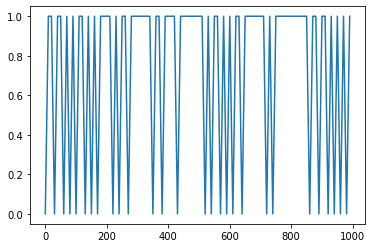

In [66]:
times2 = deltaTau*lag*np.array(steps)
plt.plot(times2,tr)

In [67]:
probs_msm = [np.mean(np.array(tr)==0), np.mean(np.array(tr)==1)] 
print(f'probs from msm traj {probs_msm}')
print(f'probs from metadyn {pi_inf0}')

probs from msm traj [0.28, 0.72]
probs from metadyn [[0.24013543 0.75986457]]


In [68]:
rle=rle_encode(tr)
surv0_rw = np.mean([le for le,v in rle if v==0])
surv1_rw = np.mean([le for le,v in rle if v==1])
# the traj in tr has a frame lenght of lag, since is generated from the matrix
print(f'survival in 0 (from synthetic traj): {surv0_rw*lag} ')
print(f'survival in 1 (from synthetic traj): {surv1_rw*lag} ')


survival in 0 (from synthetic traj): 10.0 
survival in 1 (from synthetic traj): 25.714285714285715 


In [69]:
maxcal_mm = msm.MSM(mat)

print(f' mfpts from reweigh MaxCal MSM {(maxcal_mm.mfpt(0,1)*lag, maxcal_mm.mfpt(1,0)*lag)}')
print(f' mfpts from short MSM {(mm.mfpt(0,1), mm.mfpt(1,0))}')
print(f' mfpts from long MSM {(mm_long.mfpt(0,1), mm_long.mfpt(1,0))}')


 mfpts from reweigh MaxCal MSM (10.000005715900562, 31.64318641742081)
 mfpts from short MSM (16.33281968533109, 39.481268173994636)
 mfpts from long MSM (17.527472527472526, 36.86813186813187)
